In [1]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import time 

from datasets import load_dataset

import torch
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from diffusers import DDPMScheduler
from diffusers import DDPMPipeline

# Mac users may need device = 'mps' (intested)# not tested or experienced by MX
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

## References 
# https://github.com/huggingface/diffusion-models-class/blob/main/unit1/01_introduction_to_diffusers.ipynb
# https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/training_example.ipynb 
# https://github.com/huggingface/diffusion-models-class/tree/main/unit1#what-are-diffusion-models

cuda


In [2]:
def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im


def make_grid(images, size=64):
    """Given a list of PIL images, stack them together into a line for easy viewing"""
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im



## Prepare mnist dataset

60000
5851
BATCHES_SIZE 731.375 or len(dataloader) 731
batch_idx: 0 of 731 ; sampled images: 8
    img.shape: torch.Size([8, 3, 16, 16])
    img.dtype: torch.float32
    grid_img.shape: torch.Size([3, 20, 146])


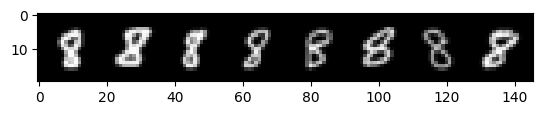

one_batch_of_images.shape: torch.Size([8, 3, 16, 16])


In [3]:
## We'll train on 16-pixel square images, but you can try larger sizes too
IMAGE_SIZE = 16
# IMAGE_SIZE = 32
# IMAGE_SIZE = 64
# IMAGE_SIZE = 128
# IMAGE_SIZE = 264

IN_CHANNELS = 3  # the number of input channels, 3 for RGB images
# IN_CHANNELS = 1  # the number of input channels, 3 for RGB images


# Define data augmentations
transform_dataset = transforms.Compose(
                [
                transforms.Grayscale(IN_CHANNELS),
                transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                #transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
                transforms.ToTensor(), #Convert to tensor (0, 1)
                transforms.Normalize((0.5,), (0.5,)) # Map to (-1, 1)
                ]
            )


dataset = torchvision.datasets.MNIST(root='../../datasets', 
                                    train=True, 
                                    download=True,
                                    transform=transform_dataset)

print(len(dataset)) #60000

##############################################
### Filtering mnist to get one one class
### https://discuss.pytorch.org/t/how-to-use-one-class-of-number-in-mnist/26276/19
#idx = (dataset.targets==0) | (dataset.targets==1)
# idx = (dataset.targets==0) 
idx = (dataset.targets==8) 
# idx = (dataset.targets==9) 
dataset.targets = dataset.targets[idx]
dataset.data = dataset.data[idx]


len_dataset=len(dataset)
print(len_dataset) 



## You can lower your batch size if you're running out of GPU memory
# BATCH_SIZE = 4
BATCH_SIZE = 8
# BATCH_SIZE = 50
# BATCH_SIZE = 100


SHUFFLE_T = True
SHUFFLE_F = False

# Data loader
dataloader = torch.utils.data.DataLoader(dataset=dataset, 
                                        batch_size=BATCH_SIZE, 
                                        shuffle=SHUFFLE_T,
                                        drop_last=True
                                        )
#######
#drop_last=True
#https://stackoverflow.com/questions/47824598/
#https://stats.stackexchange.com/questions/303857


BATCHES_SIZE=len_dataset/BATCH_SIZE
print(f'BATCHES_SIZE {BATCHES_SIZE} or len(dataloader) {len(dataloader)}')
LEN_BATCHSIZE=len(dataloader)


# for xb, yb in dataloader:
#     print(xb.shape)
#     print(yb)
#     break

## Displaying dataloader content
sampled_images=0
for batch_idx, batch in enumerate(dataloader):  #iterate through each batch    
    #print(batch_idx)
    sampled_images = sampled_images + BATCH_SIZE
    if batch_idx % 1000 == 0:
        print(f'batch_idx: {batch_idx} of { LEN_BATCHSIZE } ; sampled images: {sampled_images}')
        imgs=batch[0]
        labels=batch[1]

        print(f'    img.shape: {imgs.shape}') #torch.Size([BATCH_SIZE, 1, 64, 64])
        print(f'    img.dtype: {imgs.dtype}') #torch.Size([BATCH_SIZE, 1, 64, 64])

        grid_img = torchvision.utils.make_grid(imgs, nrow=10, normalize=True) 
        print(f'    grid_img.shape: {grid_img.shape}')#torch.Size([3, 482, 242])
        plt.imshow(grid_img.permute(1, 2, 0))
        plt.show()

        
one_batch_of_images = next(iter(dataloader))[0].to(device)
print(f'one_batch_of_images.shape: {one_batch_of_images.shape}')
show_images(one_batch_of_images)
#show_images(xb).resize((4 * IMAGE_SIZE, IMAGE_SIZE), resample=Image.Resampling(0))
# show_images(xb).resize((8 * 64, 64), resample=Image.Resampling(0))
#https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Resampling.NEAREST
#BICUBIC = 3; BILINEAR = 2; BOX = 4; HAMMING = 5; LANCZOS = 1; NEAREST = 0

        

## Define the Scheduler

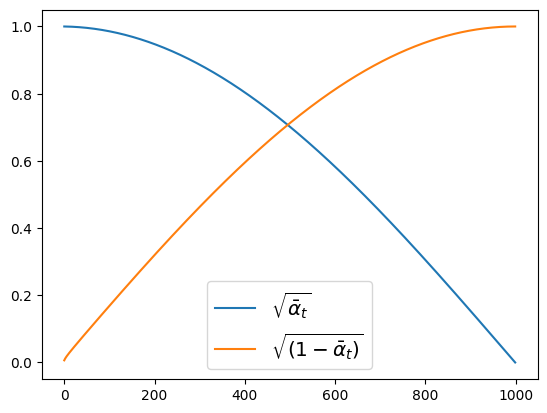

In [4]:
# from diffusers import DDPMPipeline

# ### Default linear scheduler 
# noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

### One with too little noise added:
# noise_scheduler = DDPMScheduler(num_train_timesteps=200, beta_start=0.01, beta_end=0.001)
# noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_start=0.001, beta_end=0.004)

# #### The 'cosine' schedule, which may be better for small image sizes:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");


timesteps torch.Size([8]), tensor([  0, 142, 285, 428, 570, 713, 856, 999], device='cuda:0')
Noisy X shape: torch.Size([8, 3, 16, 16])


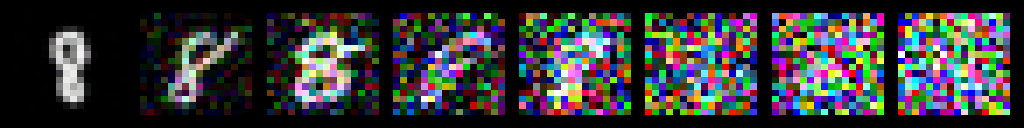

In [5]:
timesteps = torch.linspace(0, 999, BATCH_SIZE).long().to(device)
print(f'timesteps {timesteps.shape}, {timesteps}')
noise = torch.randn_like(one_batch_of_images)
noisy_xb = noise_scheduler.add_noise(one_batch_of_images, noise, timesteps)
print(f'Noisy X shape: {noisy_xb.shape}')
show_images(noisy_xb).resize((BATCH_SIZE * 128, 128), resample=Image.Resampling(0))


## Define the Model

In [6]:
from diffusers import UNet2DModel

# Create a model
model = UNet2DModel(
    sample_size=IMAGE_SIZE,  # the target image resolution
    in_channels=IN_CHANNELS,  # the number of input channels, 3 for RGB images
    out_channels=IN_CHANNELS,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(64, 128, 128, 256),  # More channels -> more parameters
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)
model.to(device);



In [7]:
## Sanity check for model_prediciton shape
with torch.no_grad():
    model_prediction = model(noisy_xb, timesteps).sample
model_prediction.shape



torch.Size([8, 3, 16, 16])

## Training Loop

In [8]:

optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)

losses = []
# epoch_number = 30 from the example
# epoch_number = 5
epoch_number = 30


start_time_train_loop = time.time_ns()
for epoch in range(epoch_number):
    start_time = time.time_ns()
    for batch_idx, batch in enumerate(dataloader):
        #print(batch_idx)
        #clean_images = batch["images"].to(device)
        clean_images=batch[0].to(device)
        #labels=batch[1]
        
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        #batch_size = clean_images.shape[0] #==BATCH_SIZE

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0, noise_scheduler.num_train_timesteps, (BATCH_SIZE,), device=clean_images.device
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
        #print(noisy_images.shape)#torch.Size([BATCH_SIZE, IN_CHANNELS, IMAGE_SIZE, IMAGE_SIZE])

        # Get the model prediction
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
        #print(noise_pred.shape)#torch.Size([BATCH_SIZE, IN_CHANNELS, IMAGE_SIZE, IMAGE_SIZE])

        # Calculate the loss
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())

        # Update the model parameters with the optimizer
        optimizer.step()
        optimizer.zero_grad()

    if (epoch + 1) % 2 == 0:
        loss_last_epoch = sum(losses[-len(dataloader) :]) / len(dataloader)
        print(f'   Epoch:{epoch+1}, loss: {loss_last_epoch}')
    print(f'      Epoch {epoch} Elapse time one epoch: { (time.time_ns() - start_time) / 1e9 } secs')


print(f'Elapse time of train loop: { (time.time_ns() - start_time_train_loop) / 1e9 } secs')    

      Epoch 0 Elapse time one epoch: 28.568221187 secs
   Epoch:2, loss: 0.062124530643367405
      Epoch 1 Elapse time one epoch: 28.628054508 secs
      Epoch 2 Elapse time one epoch: 28.713619853 secs
   Epoch:4, loss: 0.04726023782075226
      Epoch 3 Elapse time one epoch: 28.498184356 secs
      Epoch 4 Elapse time one epoch: 28.639245751 secs
   Epoch:6, loss: 0.04165943031914012
      Epoch 5 Elapse time one epoch: 28.910472051 secs
      Epoch 6 Elapse time one epoch: 28.695618103 secs
   Epoch:8, loss: 0.03892618882509328
      Epoch 7 Elapse time one epoch: 28.572335375 secs
      Epoch 8 Elapse time one epoch: 28.629984269 secs
   Epoch:10, loss: 0.03666054846135398
      Epoch 9 Elapse time one epoch: 28.692073855 secs
      Epoch 10 Elapse time one epoch: 28.64413494 secs
   Epoch:12, loss: 0.03558228961695317
      Epoch 11 Elapse time one epoch: 28.77761107 secs
      Epoch 12 Elapse time one epoch: 28.52796258 secs
   Epoch:14, loss: 0.03452845186596448
      Epoch 13 

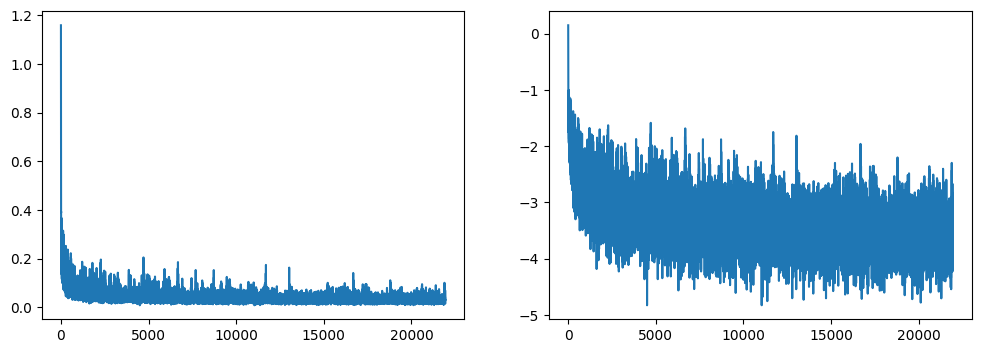

In [9]:
## plot raw losses  and log(losses)
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()



## Generate Images

### Option 1: Creating a pipeline

In [10]:
image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)

In [11]:
pipeline_output = image_pipe()


  0%|          | 0/1000 [00:00<?, ?it/s]

(16, 16)


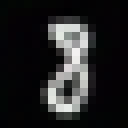

In [12]:
print(pipeline_output.images[0].size)
pipeline_output.images[0].resize((1 * 128, 128), resample=Image.Resampling(0))


In [13]:
image_pipe.save_pretrained("my_pipeline")

In [14]:
ls -la my_pipeline/

total 20
drwxrwxr-x 4 mxochicale mxochicale 4096 Jan 16 23:50 ./
drwxrwxr-x 4 mxochicale mxochicale 4096 Feb  5 01:55 ../
-rw-rw-r-- 1 mxochicale mxochicale  181 Feb  5 01:56 model_index.json
drwxrwxr-x 2 mxochicale mxochicale 4096 Jan 16 23:50 scheduler/
drwxrwxr-x 2 mxochicale mxochicale 4096 Jan 17 08:00 unet/


### Option 2: Writing a Sampling Loop

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


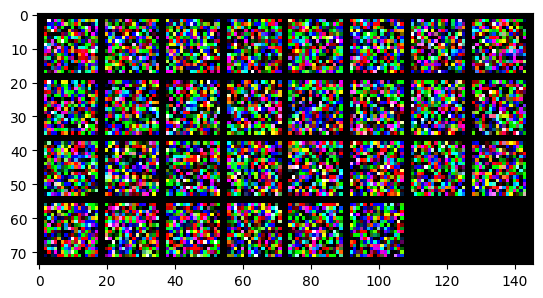

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


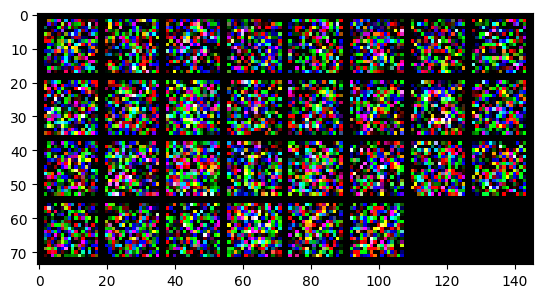

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


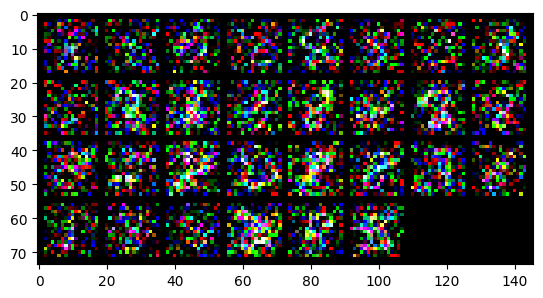

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


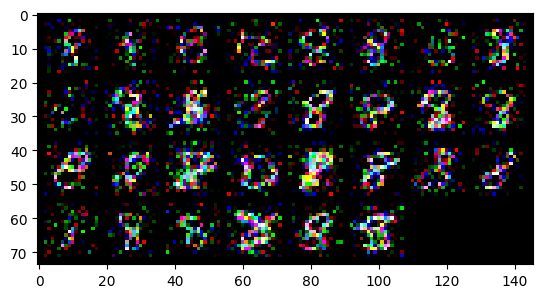

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


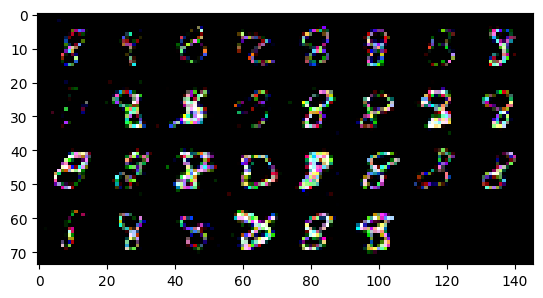

In [27]:
# Random starting point (number_of_samples random images):
number_of_samples = 30
sample = torch.randn(number_of_samples, IN_CHANNELS, IMAGE_SIZE, IMAGE_SIZE).to(device)


for idx, timesteps_ in enumerate(noise_scheduler.timesteps):
    #print(idx)#index
    #print(timesteps_)#sample
    
    ### Get model pred
    with torch.no_grad():
        residual = model(sample, timesteps_).sample

    # Update sample with step
    sample = noise_scheduler.step(residual, timesteps_, sample).prev_sample
    #print(sample.shape)#torch.Size([30, 3, 16, 16])
    

    if idx % 200 == 0:
        grid_img = torchvision.utils.make_grid(sample)
        #grid_img = torchvision.utils.make_grid(samples_img, nrow=30)
        #print(f'grid_img.shape: {grid_img.shape}') #torch.Size([3, 122, 602])
        plt.imshow(grid_img.permute(1, 2, 0).cpu().numpy()) #cmap="gray") #.numpy().astype("uint8")) 
        plt.show()

        
        #grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
        #grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
        


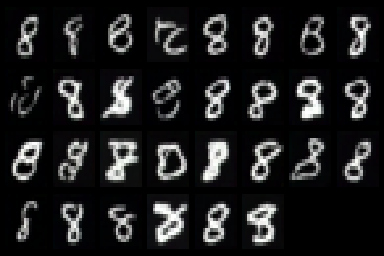

In [39]:
#Display last batch
show_images(sample).resize((8 * IMAGE_SIZE*3, 4 * IMAGE_SIZE*4), resample=Image.Resampling(0))
